Neglate phase angle difference, charging and discharging rate

In [128]:
import grid_loader as gl
import pandas as pd
import numpy as np
import pandapower as pp
import time

In [129]:
# Test case
n_case = 9

# Load test case
net = gl.load_test_case_grid(n_case)


In [130]:
# Define time periods
time_periods = range(0, 24)  # T
time_periods_plus = range(1, 25)  # T+1

# Define parameters
SOC_min = 0.3
SOC_max = 1
charging_rate = 0.0037 # 3.7kWh


In [131]:

# Get load data
df_load_p = pd.read_csv("../Evaluation/Case%s/load_p.csv"%(n_case)).transpose()
df_load_q = pd.read_csv("../Evaluation/Case%s/load_q.csv"%(n_case)).transpose()

# Get renewable energy data
df_renewable = pd.read_csv("../Evaluation/Case%s/renewable.csv"%(n_case)).transpose()

# Get EV data
df_EV_spec = pd.read_csv("../Evaluation/Case%s/EV_spec.csv"%(n_case))
# df_SOC_threshold = pd.read_csv("../Evaluation/Case%s/Case%s_%s/SOC_threshold.csv"%(n_case)) 
df_EV_SOC = pd.read_csv("../Evaluation/Case%s/ev_soc.csv"%(n_case)).transpose()
df_EV_demand = pd.read_csv("../Evaluation/Case%s/ev_demand.csv"%(n_case)).transpose()
N_D = len(net.load.index)

max_e_mwh = []
# create storage as EV
for i in net.load.index:
    bus = net.load.loc[i, "bus"]
    n_car = int(net.load.loc[i, "p_mw"])  # number of EVs connected to the bus is assumed to be integer of nominal power of the loads
    max_e_mwh.append(df_EV_spec.loc[df_EV_spec["bus"] == bus, "max_e_mwh"].values[0]/n_car)
    init_soc = df_EV_SOC.loc[:,0].iloc[i]
    pp.create_storage(
        net,
        bus=bus,
        p_mw=0,
        max_e_mwh= max_e_mwh[i],
        soc_percent=init_soc,
        min_e_mwh= 0,#df_EV_SOC.loc[:,0].iloc[i]*df_EV_spec.loc[df_EV_spec["bus"] == bus, "max_e_mwh"].values[0]/n_car,
        index=i,
        scaling=n_car,
        in_service=True,
        max_p_mw= min(0.0037, max_e_mwh[i]*(1-init_soc)),
        min_p_mw= max(-0.0037, -max_e_mwh[i]*init_soc),  #min((df_SOC_threshold.loc[t, str(i)] - updated_SOC) * max_e_mwh[i], 0.022)
        max_q_mvar=0,
        min_q_mvar=0,
        controllable=True,
    )
    df_EV_demand.iloc[i] = df_EV_demand.iloc[i]/net.storage.loc[i, "scaling"]

    # pp.create_load(net, bus=bus, p_mw=0, q_mvar=0, name="load_EV", index=i+N_D, in_service=True, type=None)


In [132]:
# if n_case == 14:
#     for i in net.gen.index:
#         if net.gen.loc[i, "vm_pu"] > net.bus.loc[net.gen.loc[i, "bus"], "max_vm_pu"]:
#             net.gen.loc[i, "vm_pu"] = net.bus.loc[net.gen.loc[i, "bus"], "max_vm_pu"]
#         if net.gen.loc[i, "vm_pu"] < net.bus.loc[net.gen.loc[i, "bus"], "min_vm_pu"]:
#             net.gen.loc[i, "vm_pu"] = net.bus.loc[net.gen.loc[i, "bus"], "min_vm_pu"]

In [133]:
# Save results
df_cost = pd.DataFrame(index=time_periods)
df_gen_p = pd.DataFrame(index=time_periods, columns=net.gen.index)
df_gen_q = pd.DataFrame(index=time_periods, columns=net.gen.index)
df_charge = pd.DataFrame(index=time_periods, columns=net.storage.index)
df_soc = pd.DataFrame(index=time_periods, columns=net.storage.index)
IPtime = []
for t in time_periods:
    print("Time period: ", t)
    if t == 0:
        net.storage.loc[:, "soc_percent"] = df_EV_SOC.loc[:, t].values
        for i in range(N_D):
            # if net.storage.loc[i, "in_service"] == True:
            future_SOC = (net.storage.loc[i, "soc_percent"]* max_e_mwh[i] - df_EV_demand.loc[:,0].iloc[i])/max_e_mwh[i]
            if future_SOC <= SOC_min:
                # no discharging allowed 
                net.storage.loc[i, "min_p_mw"] = min(charging_rate, (SOC_min - future_SOC) * max_e_mwh[i])
                net.storage.loc[i, "max_p_mw"] = min(charging_rate, max_e_mwh[i]*(1-future_SOC))
            else:
                net.storage.loc[i, "min_p_mw"] = max(-charging_rate, max_e_mwh[i] * (SOC_min - future_SOC))
                net.storage.loc[i, "max_p_mw"] = min(charging_rate, max_e_mwh[i]*(1-future_SOC))

    for i in range(N_D):
        # Load data
        net.load.loc[i, "p_mw"] = df_load_p.loc[:,t].iloc[i]
        net.load.loc[i, "q_mvar"] = df_load_q.loc[:,t].iloc[i]

        if df_EV_demand.loc[:,t].iloc[i] == 0:
            net.storage.loc[i, "in_service"] = True
        else:
            net.storage.loc[i, "in_service"] = False


    # Renewable energy data
    net.gen.loc[:, "max_p_mw"]= df_renewable.loc[:, t].values

    # Record SOC at the beginning of the time period
    df_soc.loc[t] = net.storage.loc[:, "soc_percent"]

    # Run optimal power flow
    start_time = time.process_time()
    pp.runopp(net, verbose=False)
    IPtime.append(time.process_time() - start_time)

    df_cost.loc[t,"Cost $/hr"] = net.res_cost
    df_gen_p.loc[t] = net.res_gen.loc[:, "p_mw"]
    df_gen_q.loc[t] = net.res_gen.loc[:, "q_mvar"]
    df_charge.loc[t] = net.res_storage.loc[:, "p_mw"]

    # Update EV charging limits
    if t != 23:
        # update SOC
        for i in range(N_D):
            net.storage.loc[i, "p_mw"] = net.res_storage.loc[i, "p_mw"]
            net.storage.loc[i, "soc_percent"] = (net.storage.loc[i, "soc_percent"] * max_e_mwh[i] - df_EV_demand.loc[:,t].iloc[i] + net.res_storage.loc[i, "p_mw"]) / net.storage.loc[i, "max_e_mwh"]
            future_SOC = (net.storage.loc[i, "soc_percent"]* max_e_mwh[i] - df_EV_demand.loc[:,t+1].iloc[i])/max_e_mwh[i]
            if future_SOC <= SOC_min:
                # no discharging allowed 
                net.storage.loc[i, "min_p_mw"] = min(charging_rate, (SOC_min - future_SOC) * max_e_mwh[i])
                net.storage.loc[i, "max_p_mw"] = min(charging_rate, max_e_mwh[i]*(1-future_SOC))
            elif future_SOC >= SOC_max:
                # no charging allowed 
                net.storage.loc[i, "min_p_mw"] = max(-charging_rate, max_e_mwh[i] * (SOC_min - future_SOC))
                net.storage.loc[i, "max_p_mw"] =  max(-charging_rate, max_e_mwh[i]*(SOC_max-future_SOC))
            else:
                net.storage.loc[i, "min_p_mw"] = max(-charging_rate, max_e_mwh[i] * (SOC_min - future_SOC))
                net.storage.loc[i, "max_p_mw"] = min(charging_rate, max_e_mwh[i]*(1-future_SOC))
    
    df_soc.loc[t+1] = net.storage.loc[:, "soc_percent"]
total_IPtime = sum(IPtime)


Time period:  0
Time period:  1
Time period:  2
Time period:  3
Time period:  4
Time period:  5
Time period:  6
Time period:  7
Time period:  8
Time period:  9
Time period:  10
Time period:  11
Time period:  12
Time period:  13
Time period:  14
Time period:  15
Time period:  16
Time period:  17
Time period:  18
Time period:  19
Time period:  20
Time period:  21
Time period:  22
Time period:  23


In [134]:
net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,min_p_mw,max_p_mw,min_q_mvar,max_q_mvar,controllable
0,None,4,-0.000004,0.0,NaN,0.300041,0.0,0.04500,90.0,True,None,-0.000002,0.0037,0.0,0.0,True
1,None,6,-0.000004,0.0,NaN,0.300045,0.0,0.04500,100.0,True,None,-0.000002,0.0037,0.0,0.0,True
2,None,8,-0.000004,0.0,NaN,0.300042,0.0,0.04561,125.0,True,None,-0.000002,0.0037,0.0,0.0,True


<Axes: >

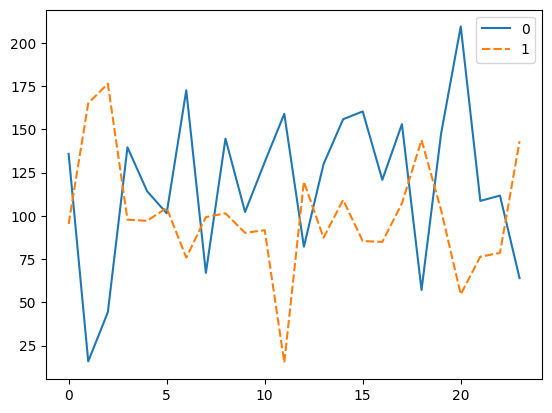

In [135]:
import seaborn as sns

# Plot results
sns.lineplot(data= df_gen_p)

<Axes: >

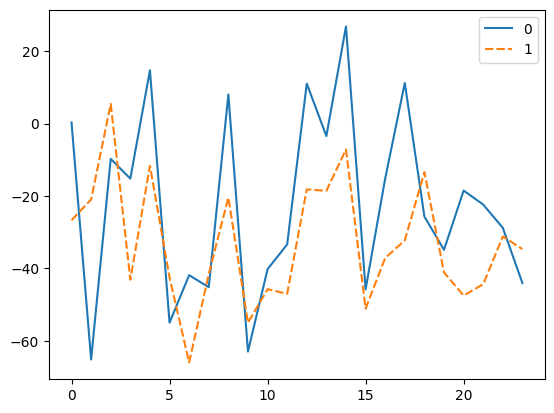

In [136]:
sns.lineplot(data= df_gen_q)

<Axes: >

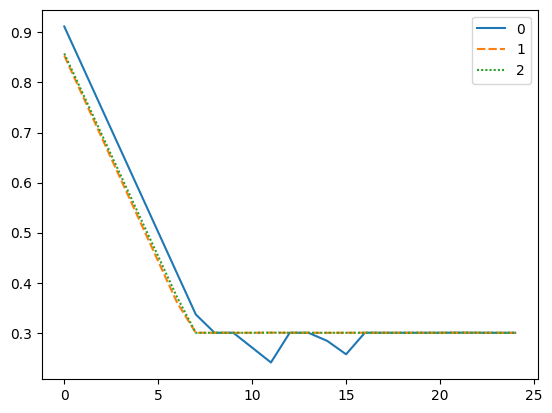

In [137]:
sns.lineplot(data= df_soc)

<Axes: >

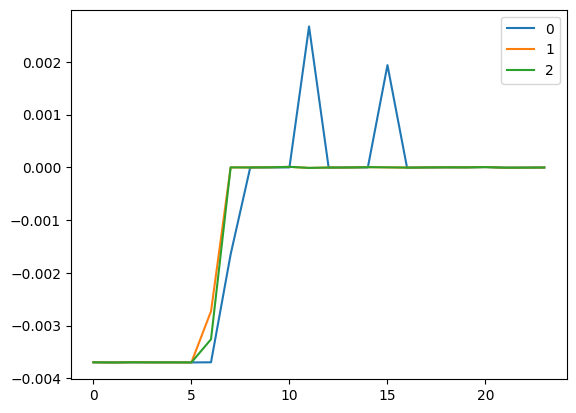

In [138]:
df_charge.plot()

In [139]:
df_cost.sum()

Cost $/hr    144298.60981
dtype: float64

In [140]:
total_IPtime

14.786106000000018